# Automated MLflow tracking in MLlib

MLflow provides automated tracking for model tuning with MLlib. With automated MLflow tracking, when you run tuning code using `CrossValidator` or `TrainValidationSplit`, the specified hyperparameters and evaluation metrics are automatically logged, making it easy to identify the optimal model.

This notebook shows an example of automated MLflow tracking with MLlib. 

This notebook uses the PySpark classes `DecisionTreeClassifier` and `CrossValidator` to train and tune a model. MLflow automatically tracks the learning process, saving the results of each run so you can examine the hyperparameters to understand the impact of each one on the model's performance and find the optimal settings.

This notebook uses the MNIST handwritten digit recognition dataset, which is included with Databricks.

## Load the training and test datasets

The dataset is already divided into training and test sets. Each dataset has two columns: an image, represented as a vector of 784 pixels, and a "label", or the actual number shown in the image.

The datasets are stored in the LIBSVM dataset format.  Load them using the MLlib LIBSVM dataset reader utility.

In [0]:
# Install mlflow
%pip install mlflow

Python interpreter will be restarted.
Collecting mlflow
 Downloading mlflow-2.2.2-py3-none-any.whl (17.6 MB)
Collecting docker<7,>=4.0.0
 Downloading docker-6.0.1-py3-none-any.whl (147 kB)
Collecting gitpython<4,>=2.1.0
 Downloading GitPython-3.1.31-py3-none-any.whl (184 kB)
Collecting shap<1,>=0.40
 Downloading shap-0.41.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (575 kB)
Collecting querystring-parser<2
 Downloading querystring_parser-1.2.4-py2.py3-none-any.whl (7.9 kB)
Collecting sqlalchemy<3,>=1.4.0
 Downloading SQLAlchemy-2.0.6-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.8 MB)
Requirement already satisfied: protobuf<5,>=3.12.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.17.2)
Collecting cloudpickle<3
 Downloading cloudpickle-2.2.1-py3-none-any.whl (25 kB)
Collecting pyyaml<7,>=5.1
 Downloading PyYAML-6.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (701 kB)
Requirement already satisfied: pandas<3 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.2.4)
Requirement already satisfied: scipy<2 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.6.2)
Requirement already satisfied: entrypoints<1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.3)
Requirement already satisfied: scikit-learn<2 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.24.1)
Requirement already satisfied: requests<3,>=2.17.3 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.25.1)
Requirement already satisfied: numpy<2 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.20.1)
Collecting gunicorn<21
 Downloading gunicorn-20.1.0-py3-none-any.whl (79 kB)
Collecting alembic<2
 Downloading alembic-1.10.2-py3-none-any.whl (212 kB)
Collecting Flask<3
 Downloading Flask-2.2.3-py3-none-any.whl (101 kB)
Collecting markdown<4,>=3.3
 Downloading Markdown-3.4.1-py3-none-any.whl (93 kB)
Requirement already satisfied: pytz<2023 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2020.5)
Requirement already satisfied: Jinja2<4,>=2.11 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.11.3)
Requirement already satisfied: packaging<24 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (20.9)
Collecting databricks-cli<1,>=0.8.7
 Downloading databricks-cli-0.17.5.tar.gz (82 kB)
Collecting importlib-metadata!=4.7.0,<7,>=3.7.0
 Downloading importlib_metadata-6.0.0-py3-none-any.whl (21 kB)
Requirement already satisfied: matplotlib<4 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.4.2)
Requirement already satisfied: click<9,>=7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (8.1.3)
Collecting sqlparse<1,>=0.4.0
 Downloading sqlparse-0.4.3-py3-none-any.whl (42 kB)
Requirement already satisfied: pyarrow<12,>=4.0.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (4.0.0)
Collecting importlib-resources
 Downloading importlib_resources-5.12.0-py3-none-any.whl (36 kB)
Collecting typing-extensions>=4
 Downloading typing_extensions-4.5.0-py3-none-any.whl (27 kB)
Collecting Mako
 Downloading Mako-1.2.4-py3-none-any.whl (78 kB)
Collecting pyjwt>=1.7.0
 Downloading PyJWT-2.6.0-py3-none-any.whl (20 kB)
Collecting oauthlib>=3.1.0
 Downloading oauthlib-3.2.2-py3-none-any.whl (151 kB)
Collecting tabulate>=0.7.7
 Downloading tabulate-0.9.0-py3-none-any.whl (35 kB)
Requirement already satisfied: six>=1.10.0 in /databricks/python3/lib/python3.8/site-packages (from databricks-cli<1,>=0.8.7->mlflow) (1.15.0)
Collecting urllib3>=1.26.0
 Downloading urllib3-1.26.15-py2.py3-none-any.whl (140 kB)
Collecting websocket-client>=0.32.0
 Downloading websocket_client-1.5.1-py3-none-any.whl (55 kB)
Collecting requests<3,>=2.17.3
 Downloading requests-2.28.2-py3-none-any.whl (62 kB)
Collecting Jinja2<4,>=2.11
 Downloading Jinja2-3.1.2-py3-none-any.whl (133 kB)
Collecting Werkzeug>=2.2.2
 Downloading Werkzeu

In [0]:
training = spark.read.format("libsvm") \
  .option("numFeatures", "784") \
  .load("/databricks-datasets/mnist-digits/data-001/mnist-digits-train.txt")
test = spark.read.format("libsvm") \
  .option("numFeatures", "784") \
  .load("/databricks-datasets/mnist-digits/data-001/mnist-digits-test.txt")

training.cache()
test.cache()

print("There are {} training images and {} test images.".format(training.count(), test.count()))

There are 60000 training images and 10000 test images.

Display the data.  Each image has the true label (the `label` column) and a vector of `features` that represent pixel intensities.

In [0]:
display(training)

label features 5.0 Map(vectorType -> sparse, length -> 784, indices -> List(152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 260, 261, 262, 263, 264, 265, 266, 268, 269, 289, 290, 291, 292, 293, 319, 320, 321, 322, 347, 348, 349, 350, 376, 377, 378, 379, 380, 381, 405, 406, 407, 408, 409, 410, 434, 435, 436, 437, 438, 439, 463, 464, 465, 466, 467, 493, 494, 495, 496, 518, 519, 520, 521, 522, 523, 524, 544, 545, 546, 547, 548, 549, 550, 551, 570, 571, 572, 573, 574, 575, 576, 577, 578, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 676, 677, 678, 679, 680, 681, 682, 683), values -> List(3.0, 18.0, 18.0, 18.0, 126.0, 136.0, 175.0, 26.0, 166.0, 255.0, 247.0, 127.0, 30.0, 36.0, 94.0, 154.0, 170.0, 253.0, 253.0, 253.0, 253.0, 253.0, 225.0, 172.0, 253.0, 242.0, 195.0, 64.0, 49.0, 238.0, 253.0, 253.0, 253.0, 253.0, 253.0, 253.0, 253.0, 253.0, 251.0, 93.0, 82.0, 82.0, 56.0, 39.0, 18.0, 219.0, 253.0, 253.0, 253.0, 253.0, 253.0, 198.0, 182.0, 247.0, 241.0, 80.0, 156.0, 107.0, 253.0, 253.0, 205.0, 11.0, 43.0, 154.0, 14.0, 1.0, 154.0, 253.0, 90.0, 139.0, 253.0, 190.0, 2.0, 11.0, 190.0, 253.0, 70.0, 35.0, 241.0, 225.0, 160.0, 108.0, 1.0, 81.0, 240.0, 253.0, 253.0, 119.0, 25.0, 45.0, 186.0, 253.0, 253.0, 150.0, 27.0, 16.0, 93.0, 252.0, 253.0, 187.0, 249.0, 253.0, 249.0, 64.0, 46.0, 130.0, 183.0, 253.0, 253.0, 207.0, 2.0, 39.0, 148.0, 229.0, 253.0, 253.0, 253.0, 250.0, 182.0, 24.0, 114.0, 221.0, 253.0, 253.0, 253.0, 253.0, 201.0, 78.0, 23.0, 66.0, 213.0, 253.0, 253.0, 253.0, 253.0, 198.0, 81.0, 2.0, 18.0, 171.0, 219.0, 253.0, 253.0, 253.0, 253.0, 195.0, 80.0, 9.0, 55.0, 172.0, 226.0, 253.0, 253.0, 253.0, 253.0, 244.0, 133.0, 11.0, 136.0, 253.0, 253.0, 253.0, 212.0, 135.0, 132.0, 16.0)) 0.0 Map(vectorType -> sparse, length -> 784, indices -> List(127, 128, 129, 130, 131, 154, 155, 156, 157, 158, 159, 181, 182, 183, 184, 185, 186, 187, 188, 189, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 289, 290, 291, 292, 293, 294, 295, 296, 297, 300, 301, 302, 316, 317, 318, 319, 320, 321, 328, 329, 330, 343, 344, 345, 346, 347, 348, 349, 356, 357, 358, 371, 372, 373, 374, 384, 385, 386, 399, 400, 401, 412, 413, 414, 426, 427, 428, 429, 440, 441, 442, 454, 455, 456, 457, 466, 467, 468, 469, 470, 482, 483, 484, 493, 494, 495, 496, 497, 510, 511, 512, 520, 521, 522, 523, 538, 539, 540, 547, 548, 549, 550, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 622, 623, 624, 625, 626, 627, 628, 629, 630, 651, 652, 653, 654, 655, 656, 657), values -> List(51.0, 159.0, 253.0, 159.0, 50.0, 48.0, 238.0, 252.0, 252.0, 252.0, 237.0, 54.0, 227.0, 253.0, 252.0, 239.0, 233.0, 252.0, 57.0, 6.0, 10.0, 60.0, 224.0, 252.0, 253.0, 252.0, 202.0, 84.0, 252.0, 253.0, 122.0, 163.0, 252.0, 252.0, 252.0, 253.0, 252.0, 252.0, 96.0, 189.0, 253.0, 167.0, 51.0, 238.0, 253.0, 253.0, 190.0, 114.0, 253.0, 228.0, 47.0, 79.0, 255.0, 168.0, 48.0, 238.0, 252.0, 252.0, 179.0, 12.0, 75.0, 121.0, 21.0, 253.0, 243.0, 50.0, 38.0, 165.0, 253.0, 233.0, 208.0, 84.0, 253.0, 252.0, 165.0, 7.0, 178.0, 252.0, 240.0, 71.0, 19.0, 28.0, 253.0, 252.0, 195.0, 57.0, 252.0, 252.0, 63.0, 253.0, 252.0, 195.0, 198.0, 253.0, 190.0, 255.0, 253.0, 196.0, 76.0, 246.0, 252.0, 112.0, 253.0, 252.0, 148.0, 85.0, 252.0, 230.0, 25.0, 7.0, 135.0, 253.0, 186.0, 12.0, 85.0, 252.0, 223.0, 7.0, 131.0, 252.0, 225.0, 71.0, 85.0, 252.0, 145.0, 48.0, 165.0, 252.0, 173.0, 86.0, 253.0, 225.0, 114.0, 238.0, 253.0, 162.0, 85.0, 252.0, 249.0, 146.0, 48.0, 29.0, 85.0, 178.0, 225.0, 253.0, 223.0, 167.0, 56.0, 85.0, 252.0, 252.

## Define the ML pipeline 

In this example, as with most ML applications, you must do some preprocessing of the data before you can use the data to train a model. MLlib provides **pipelines** that allow you to combine multiple steps into a single workflow. In this example, you build a two-step pipeline:
1. `StringIndexer` converts the labels from numeric values to categorical values. 
2. `DecisionTreeClassifier` trains a decision tree that can predict the "label" column based on the data in the "features" column.

For more information:  
[Pipelines](http://spark.apache.org/docs/latest/ml-pipeline.html#ml-pipelines)

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier, DecisionTreeClassificationModel
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
import mlflow
mlflow.pyspark.ml.autolog()

In [0]:
# StringIndexer: Convert the input column "label" (digits) to categorical values
indexer = StringIndexer(inputCol="label", outputCol="indexedLabel")
# DecisionTreeClassifier: Learn to predict column "indexedLabel" using the "features" column
dtc = DecisionTreeClassifier(labelCol="indexedLabel")
# Chain indexer + dtc together into a single ML Pipeline
pipeline = Pipeline(stages=[indexer, dtc])

## Run the cross-validation 

Now that you have defined the pipeline, you can run the cross validation to tune the model's hyperparameters. During this process, MLflow automatically tracks the models produced by `CrossValidator`, along with their evaluation metrics. This allows you to investigate how specific hyperparameters affect the model's performance.

In this example, you examine two hyperparameters in the cross-validation:

* `maxDepth`. This parameter determines how deep, and thus how large, the tree can grow. 
* `maxBins`. For efficient distributed training of Decision Trees, MLlib discretizes (or "bins") continuous features into a finite number of values. The number of bins is controlled by `maxBins`. In this example, the number of bins corresponds to the number of grayscale levels; `maxBins=2` turns the images into black and white images.

For more information:  
[maxBins](https://spark.apache.org/docs/latest/mllib-decision-tree.html#split-candidates)  
[maxDepth](https://spark.apache.org/docs/latest/mllib-decision-tree.html#stopping-rule)

In [0]:
# Create an evaluator.  In this case, use "weightedPrecision".
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", metricName="weightedPrecision")

In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [0]:
# Define the parameter grid to examine.
grid = (ParamGridBuilder() #\
  .addGrid(dtc.maxDepth, [2, 3, 4, 5, 6, 7, 8]) \
  .addGrid(dtc.maxBins, [2, 4, 8]) \
  .build())

In [0]:
# Create a cross validator, using the pipeline, evaluator, and parameter grid you created in previous steps.
cv = CrossValidator(estimator=pipeline, evaluator=evaluator, estimatorParamMaps=grid, numFolds=3)

Run `CrossValidator`.  If an MLflow tracking server is available, `CrossValidator` automatically logs each run to MLflow, along with the evaluation metric calculated on the held-out data, under the current active run. If no run is active, a new one is created.

In [0]:
# Explicitly create a new run.
# This allows this cell to be run multiple times.
# If you omit mlflow.start_run(), then this cell could run once, but a second run would hit conflicts when attempting to overwrite the first run.
import mlflow
import mlflow.spark

with mlflow.start_run():
  # Run the cross validation on the training dataset. The cv.fit() call returns the best model it found.
  cvModel = cv.fit(training)
  
  # Evaluate the best model's performance on the test dataset and log the result.
  test_metric = evaluator.evaluate(cvModel.transform(test))
  mlflow.log_metric('test_' + evaluator.getMetricName(), test_metric) 
  
  # Log the best model.
  mlflow.spark.log_model(spark_model=cvModel.bestModel, artifact_path='best-model') 

2023/03/14 19:54:41 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2023/03/14 19:55:26 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2023/03/14 19:56:08 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().

## Review the logged results

To view the MLflow experiment associated with the notebook, click the **Experiment** icon in the notebook context bar on the upper right. All notebook runs appear in the sidebar. 
To more easily compare their results, click the icon at the far right of **Experiment Runs** (it shows "View Experiment UI" when you hover over it). The Experiment page appears.

For example, to examine the effect of tuning `maxDepth`:

1. On the Experiment page, enter `params.maxBins = "8"` in the **Search Runs** box, and click **Search**.
1. Select the resulting runs and click **Compare**.
1. In the Scatter Plot, select X-axis **maxDepth** and Y-axis **avg_weightedPrecision**.

You can see that, when `maxBins` is held constant at 8, the average weighted precision increases with `maxDepth`.

# Use The Best Model to Make Predictions

From the "View Experiment UI" page, you can click on the most recent set of runs. There is a code block below that which tells you exactly how to recall the best model from that set of runs.

In [0]:
import mlflow
logged_model = 'runs:/916d6cdc92314982801b1821043c126c/best-model'

# Load model
loaded_model = mlflow.spark.load_model(logged_model)

2023/03/14 19:58:28 INFO mlflow.spark: 'runs:/916d6cdc92314982801b1821043c126c/best-model' resolved as 'dbfs:/databricks/mlflow-tracking/4276130692229565/916d6cdc92314982801b1821043c126c/artifacts/best-model'

In [0]:
data = test

# Perform inference via model.transform()
result = loaded_model.transform(data)

In [0]:
display(result["label", "indexedLabel", "prediction", "rawPrediction", "probability"])

label indexedLabel prediction rawPrediction probability 7.0 1.0 1.0 Map(vectorType -> dense, length -> 10, values -> List(12.0, 4261.0, 25.0, 63.0, 76.0, 2.0, 0.0, 5.0, 4.0, 8.0)) Map(vectorType -> dense, length -> 10, values -> List(0.0026929982046678637, 0.9562387791741472, 0.005610412926391382, 0.014138240574506284, 0.017055655296229804, 4.488330341113106E-4, 0.0, 0.0011220825852782765, 8.976660682226212E-4, 0.0017953321364452424)) 2.0 3.0 3.0 Map(vectorType -> dense, length -> 10, values -> List(2.0, 0.0, 9.0, 24.0, 0.0, 16.0, 16.0, 2.0, 0.0, 18.0)) Map(vectorType -> dense, length -> 10, values -> List(0.022988505747126436, 0.0, 0.10344827586206896, 0.27586206896551724, 0.0, 0.1839080459770115, 0.1839080459770115, 0.022988505747126436, 0.0, 0.20689655172413793)) 1.0 0.0 0.0 Map(vectorType -> dense, length -> 10, values -> List(5338.0, 48.0, 32.0, 66.0, 11.0, 0.0, 18.0, 91.0, 36.0, 60.0)) Map(vectorType -> dense, length -> 10, values -> List(0.9364912280701755, 0.008421052631578947, 0.005614035087719298, 0.011578947368421053, 0.0019298245614035089, 0.0, 0.003157894736842105, 0.015964912280701755, 0.00631578947368421, 0.010526315789473684)) 0.0 5.0 5.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 7.0, 10.0, 3.0, 3587.0, 10.0, 0.0, 0.0, 9.0)) Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 0.0019305019305019305, 0.0027578599007170436, 8.27357970215113E-4, 0.9892443463872035, 0.0027578599007170436, 0.0, 0.0, 0.002482073910645339)) 4.0 8.0 8.0 Map(vectorType -> dense, length -> 10, values -> List(12.0, 83.0, 18.0, 52.0, 69.0, 13.0, 31.0, 25.0, 3611.0, 42.0)) Map(vectorType -> dense, length -> 10, values -> List(0.003033367037411527, 0.020980788675429726, 0.00455005055611729, 0.01314459049544995, 0.01744186046511628, 0.0032861476238624874, 0.007836198179979777, 0.006319514661274014, 0.9127906976744186, 0.010616784630940344)) 1.0 0.0 0.0 Map(vectorType -> dense, length -> 10, values -> List(5338.0, 48.0, 32.0, 66.0, 11.0, 0.0, 18.0, 91.0, 36.0, 60.0)) Map(vectorType -> dense, length -> 10, values -> List(0.9364912280701755, 0.008421052631578947, 0.005614035087719298, 0.011578947368421053, 0.0019298245614035089, 0.0, 0.003157894736842105, 0.015964912280701755, 0.00631578947368421, 0.010526315789473684)) 4.0 8.0 8.0 Map(vectorType -> dense, length -> 10, values -> List(19.0, 78.0, 39.0, 18.0, 12.0, 0.0, 81.0, 26.0, 377.0, 25.0)) Map(vectorType -> dense, length -> 10, values -> List(0.028148148148148148, 0.11555555555555555, 0.057777777777777775, 0.02666666666666667, 0.017777777777777778, 0.0, 0.12, 0.03851851851851852, 0.5585185185185185, 0.037037037037037035)) 9.0 4.0 4.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 102.0, 66.0, 16.0, 3146.0, 4.0, 2.0, 163.0, 188.0, 103.0)) Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.02691292875989446, 0.017414248021108178, 0.004221635883905013, 0.8300791556728232, 0.0010554089709762533, 5.277044854881266E-4, 0.04300791556728232, 0.049604221635883905, 0.027176781002638522)) 5.0 9.0 3.0 Map(vectorType -> dense, length -> 10, values -> List(10.0, 5.0, 12.0, 572.0, 1.0, 0.0, 17.0, 30.0, 6.0, 1.0)) Map(vectorType -> dense, length -> 10, values -> List(0.01529051987767584, 0.00764525993883792, 0.01834862385321101, 0.8746177370030581, 0.0015290519877675841, 0.0, 0.02599388379204893, 0.045871559633027525, 0.009174311926605505, 0.0015290519877675841)) 9.0 4.0 4.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 102.0, 66.0, 16.0, 3146.0, 4.0, 2.0, 163.0, 188.0, 103.0)) Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.02691292875989446, 0.017414248021108178, 0.004221635883905013, 0.8300791556728232, 0.0010554089709762533, 5.277044854881266E-4, 0.04300791556728232, 0.049604221635883905, 0.027176781002638522)) 0.0 5.0 5.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 7.0, 10.0, 3.0, 3587.0, 10.0, 0.0, 0.0, 9.0)) Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 0.0019305019305019305, 0.0027

In [0]:
import numpy as np
import matplotlib.pyplot as plt
raw_test = test.collect()

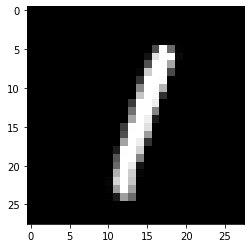

In [0]:
# Define the sparse vector
#             [item number][index of vector]
sparse_vector = raw_test[5][1]

# Convert the sparse vector to a 2D array
image = sparse_vector.toArray().reshape(28, 28)

# Display the image
plt.imshow(image, cmap='gray')
plt.show()